# VAE!

Guide here: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Subset, Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split 
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.utils as vutils
import pandas as pd
import os
from PIL import Image

import json 

In [15]:
#download the dataset 
#path = '~/datasets'
path = ('/Users/Bruger/Dropbox/UAL/critical_tech/thesis/data/australian_sea_slugs_images')

In [131]:
# this was created with the help of chatgpt 
# this code uses a defualt dataset to load in the images from the folder -> needs to be done like this as none of the images are labelled and there is no classes  

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_list = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert image to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)

        # Normalize pixel values
        image = (image - image.min()) / (image.max() - image.min())

        return image

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images 
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Create a custom dataset
dataset = CustomDataset(path, transform=transform)

# Create a DataLoader to batch and shuffle the data
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate through the data loader to fetch batches of images
for batch_images in data_loader:
    # 'batch_images' contains a batch of images
    print("Batch of loaded images shape:", batch_images.shape)
    # Perform VAE training using 'batch_images'
    break  # For demonstration, break after the first batch

Batch of loaded images shape: torch.Size([32, 3, 128, 128])


In [132]:
# Get the total number of images in the dataset
total_images = len(dataset)
print("Total number of images in the dataset:", total_images)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

Total number of images in the dataset: 2113


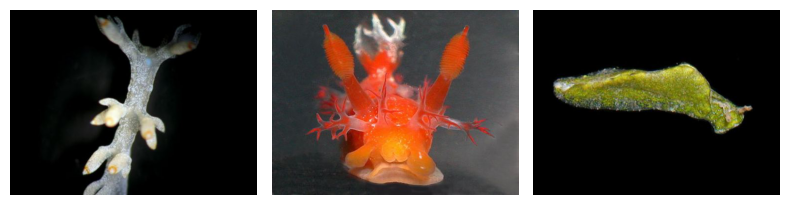

In [133]:
# look at the data in the dataset 
# look at the data 

# Get the list of image filenames
image_list = os.listdir(path)

# Load the first two images from the dataset
#image_paths = [os.path.join(path, img) for img in image_list[90:93]]
image_paths = [os.path.join(path, img) for img in image_list[689:692]]

# Display the first two images
fig, axes = plt.subplots(1, 3, figsize=(8, 4))  # Create a figure with two subplots

for i, img_path in enumerate(image_paths):
    image = Image.open(img_path)
    axes[i].imshow(image)
    #axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')  # Hide axes
plt.tight_layout()
plt.show()

Batch images shape: torch.Size([32, 3, 128, 128])


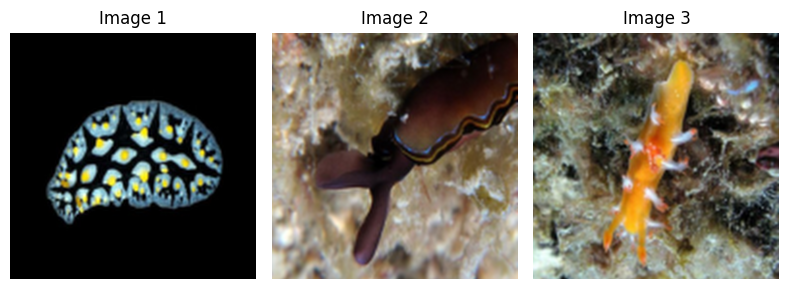

In [134]:
# look at the data loaded through the dataloader 
# Create an iterator from the DataLoader
data_iter = iter(data_loader)

# Fetch the first batch from the DataLoader
batch_images = next(data_iter)

# Display information about the batch
print(f"Batch images shape: {batch_images.shape}")

num_samples_to_display = 3
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(8, 4))

for i in range(num_samples_to_display):
    resized_image = batch_images[i].permute(1, 2, 0)  # Change tensor shape (C, H, W) to (H, W, C) for plotting
    axes[i].imshow(resized_image, interpolation='lanczos')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
    axes[i].set_xlim([0, resized_image.shape[1]])  # Set the width of the displayed image
    axes[i].set_ylim([0, resized_image.shape[0]])  # Set the height of the displayed image

plt.tight_layout()
plt.show()

In [135]:
# define the VAE 
class VAE(nn.Module):

    def __init__(self, input_dim=49152, hidden_dim=400, latent_dim=200, device=device, dropout_prop=0.5):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),      # new layer 
            nn.LeakyReLU(0.2),           # new layer
            nn.Dropout(dropout_prop),      # add dropout layer 
            nn.Linear(latent_dim, hidden_dim),  # Additional hidden layer
            nn.LeakyReLU(0.2),                  # new acitivion
            nn.Linear(hidden_dim, latent_dim*2),
            nn.LeakyReLU(0.2),
            #nn.Linear(latent_dim,2)     
            

            #self.fc1 = nn.Linear(input_dim, hidden_dim),
            #self.fc2 = nn.LeakyReLU(0.2),
            #self.fc3 = nn.Linear(hidden_dim, latent_dim),
            #self.relu = nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim*2,3)
        self.logvar_layer = nn.Linear(latent_dim*2,3)

        # create a latent space with 3 dimensions
        #self.latent_to_3d = nn.Linear(latent_dim,3)     
       
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, latent_dim),      # takes the output from the bottleneck layer (the latent space) which should be 3 dimension -> this is the data that we are capturing later to visualize the latent space
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim,hidden_dim),        # new layer 
            nn.LeakyReLU(0.2),                  # new layer 
            nn.Dropout(dropout_prop),      # add dropout layer
            nn.Linear(hidden_dim, hidden_dim),   # new layer 
            nn.LeakyReLU(0.2),                   # new layer
            nn.Dropout(dropout_prop),         # add droput layer 
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):      # x is the input data 
        x = self.encoder(x)
        #mean, logvar = torch.chunk(x, 2, dim=1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        #print(x.shape)
        return mean, logvar                # encoder returns mean and logvar, which is the information for the latent vectors: mean and log variance of the distribution in the latent space

    def reparameterization(self, mean, var):      # takes mean and logvar and performs reparameterization. This blandt andet generates a latent vector z using sampling from a distribution dfined by these parameters. 
                                                  # there is stochastity / randomness applied to the space here 
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, z):            # takes z - the latent vector - and recreates the input, x_hat
        #print(z.shape)
        x_hat = torch.sigmoid(self.decoder(z))
        return self.decoder(z)

    def forward(self, x):       # forwards the latent vectors, z and mean and logvar to the next layer
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        #z_3d = self.latent_to_3d(z)      # forward the latent space w correct dimensions

        #x_hat = torch.flatten(x)
        #x_hat = self(x,start_dim=0, end_dim=- 1)
         
        x_hat = self.decode(z)
        #print(x_hat.shape)
    
        return x_hat, mean, logvar

#x_dim = 784     # this is the dimensions of an input image 28 x 28 
#x = x.view(-1,x_dim)    # reshape data 

# pass the reshaped data to the model 
#output, mean, logvar = model(x)


In [136]:
import torch.optim as optim

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
#optimizer = adam(model.parameters(), lr=1e-3)

In [137]:
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())

    return reproduction_loss + KLD

In [138]:
# TRAIN 
# input data dimensions
x_dim = 49152  # height x width x channels 

def train(model, optimizer, epochs, device, data_loader):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(data_loader):
            x = x.view(x.size(0), -1).to(device)  # Reshape input batch if necessary

            optimizer.zero_grad()

            x_hat, mean, logvar = model(x)
            loss = loss_function(x, x_hat, mean, logvar)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / len(data_loader.dataset))
    return overall_loss

train(model, optimizer, epochs=20, device=device, data_loader=data_loader)

	Epoch 1 	Average Loss:  1.5888431308946167e+26
	Epoch 2 	Average Loss:  38628.50301518871
	Epoch 3 	Average Loss:  35430.89992568327
	Epoch 4 	Average Loss:  35089.1923148737
	Epoch 5 	Average Loss:  86578.22072253609
	Epoch 6 	Average Loss:  43690.80038008755
	Epoch 7 	Average Loss:  35824.39621724148
	Epoch 8 	Average Loss:  33499.7428789044
	Epoch 9 	Average Loss:  33179.250806022246
	Epoch 10 	Average Loss:  34520.37357097433
	Epoch 11 	Average Loss:  35389.82701024906
	Epoch 12 	Average Loss:  33907.472164502484
	Epoch 13 	Average Loss:  32908.381269780824
	Epoch 14 	Average Loss:  32566.029447542
	Epoch 15 	Average Loss:  32475.171934157595
	Epoch 16 	Average Loss:  31993.09297910258
	Epoch 17 	Average Loss:  31561.689512282595
	Epoch 18 	Average Loss:  31290.219372079093
	Epoch 19 	Average Loss:  31117.980690590983
	Epoch 20 	Average Loss:  31091.14290256744


65695584.953125

In [142]:
# save the trained model 
torch.save(model.state_dict(), '/Users/Bruger/Dropbox/UAL/critical_tech/thesis/vae_sea_slugs.pth')

# EXTRACT LATENT VECTORS 

In [140]:
from sklearn.decomposition import PCA

In [144]:
# Function to extract and save latent vectors
def extract_and_save_latent_vectors(model, data_loader, output_file):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for x in data_loader:
            x = x.view(x.size(0), -1).to(device)  # Reshape input batch if necessary

            mean, logvar = model.encode(x)
            z = model.reparameterization(mean, logvar)
            latent_vectors.extend(z.cpu().numpy().tolist())
    
    # Dimensionality reduction -> this needs to be 3 dimensions 
    #pca = PCA(n_components=n_components)
    #latent_vectors = np.array(latent_vectors)
    #latent_vectors_reduced = pca.fit_transform(latent_vectors)

    # Save latent vectors to a JSON file
    with open(output_file, 'w') as file:
        json.dump(latent_vectors, file)
    
    print(len(latent_vectors))      # check if the whole space is included! 
    #return latent_vectors

# Set the output file name for saving the latent vectors
output_file = 'latent_vectors_ægte.json'

# Call the function to extract and save latent vectors
extract_and_save_latent_vectors(model, data_loader, output_file)


2113


[[-166.49392700195312, -442.9483642578125, -329.35028076171875],
 [19.750247955322266, -58.105735778808594, -133.00155639648438],
 [198.8286590576172, 528.76220703125, 2223.841064453125],
 [-311.3435974121094, 826.501953125, 648.6126098632812],
 [17.097415924072266, -168.66477966308594, 296.7117614746094],
 [109.20109558105469, 716.8092651367188, 144.23072814941406],
 [32.50439453125, -471.0744934082031, -488.4600830078125],
 [18.223209381103516, 65.55604553222656, 67.24952697753906],
 [46.55708312988281, 39.94390869140625, 62.4477653503418],
 [59.769927978515625, 59.600563049316406, 383.506591796875],
 [27.407289505004883, -19.400310516357422, -155.9260711669922],
 [68.88812255859375, 403.7951354980469, -232.0414581298828],
 [-16.577293395996094, -97.99115753173828, -299.24749755859375],
 [22.344758987426758, 222.42376708984375, 174.35958862304688],
 [-121.7853775024414, -69.76659393310547, -922.0496826171875],
 [-144.5296173095703, -232.0980987548828, -686.15087890625],
 [8.282649040

## BROKEN CODE! 

In [53]:
# access the training data 
full_dataset = dataset['train']

# split dataset 
train_size = 0.9 
# define the amount of data in test and train 
train_indices, test_indices = train_test_split(range(len(full_dataset)),train_size=train_size, random_state=42)

# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = Subset(full_dataset, train_indices)    # takes the whole dataset and puts the amount of data into it as loaded into train and test indices 
test_dataset = Subset(full_dataset, test_indices)

#train_dataset = dataset['train']
#test_dataset = dataset['test']


# create train and test dataloaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True,collate_fn=lambda x: x) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,collate_fn=lambda x: x)

#def transform(dataset):
 #   return transform(dataset)

train_loader.dataset.transform = transform
test_loader.dataset.transform = transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(type(train_dataset))
print(type(test_dataset))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [67]:
# extract and save latent vectors!    this code is created with help from chatgpt. 
import json
import numpy as np 

# make variable for latent dimensionality global 
latent_dim = 200

# convert tensors to numpy arrays 
# Function to convert tensors to NumPy arrays and save them in JSON format
def save_tensors_to_json(tensor_list, file_path):
    numpy_list = [tensor.cpu().numpy().tolist() for tensor in tensor_list]
    with open(file_path, 'w') as file:
        json.dump(numpy_list, file)